This notebook implements simulations of missing mass and the WingIt estimator for sticky Markov chains. 

The details are in the following paper:
[PMT24] A. Pananjady, V. Muthukumar, A. Thangaraj, "Just Wing It: Optimal Estimation of Missing Mass in a Markovian Sequence"

In [1]:
import scipy.stats as st
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
#Compute missing mass (X: list of samples; stat_dist: stationary distribution)
#[PMT24]: Section 1
def MissingMass(X, stat_dist):
    Xseen = list(set(X))
    M = 1 - sum([stat_dist[x] for x in Xseen])
    return M

#WingIt estimator of missing mass (X: list of samples, n: length of X, tmix: window size, tskip: subsampling)
#Linear-time implementation
#[PMT24]: Section 3.2, 3.3
def wingit(X, n, tmix, tskip = 1):
    Xloc = {}
    for i in range(n):
        if (X[i] not in Xloc):
            Xloc[X[i]] = []
        Xloc[X[i]].append(i)
    Mhat = 0
    for i in range(0,n,tskip):
        Mhat = Mhat + int((Xloc[X[i]][0]>(i-tmix)) and (Xloc[X[i]][-1]<(i+tmix)))*tskip/n
    return min(Mhat,1)

#Validation based tuning for window size
#[PMT24]: Section 6.1, except that c in the code is C_tune * 3
def estimatetmix(X,n,c):
    nby3 = int(n/3)
    X1 = X[:nby3]
    X3 = X[n-nby3:]
    Mprime = 0
    for x in X3:
        Mprime = Mprime + int(x not in X1)/nby3
    
    tmix1 = 1
    Mhat = wingit(X1, nby3, tmix1)
    while ((Mhat - Mprime)*(Mhat - Mprime))>=(c*tmix1/n):
        tmix1 = tmix1 * 2
        Mhat = wingit(X1, nby3, tmix1)
    return tmix1

In [3]:
#Generate a sample from a sticky Markov chain with uniform stationary distribution
#n: length of sample, N: size of the alphabet (uniform distribution), al: stickiness probability
#[PMT24]: Equation (10), al = 1 - p
def stickyuniform(n,N,al):
    X = rng.integers(low = 0, high = N, size = n)
    if al > 0:
        stick = rng.binomial(n=1, p=al, size = n)
        for i in range(1,n):
            if stick[i] == 1:
                X[i] = X[i-1]
    return X

#Simulate generation of a sticky Markov chain sample, computing missing mass and estimating missing mass with WingIt
#nset: list of sample lengths n for simulation
#alset: list of stickiness parameters for simulation
#tset: list of window sizes of WingIt estimator for simulation ('est': will tune window size)
#Nrounds: number of trajectories to be simulated
def stickysimulate(nset,alset,tset,Nrounds):
    res = {(n,al,tmix):[] for n in nset for al in alset for tmix in tset}
    for n in nset:
        N = int(1.2 * n)
        stat_dist = st.randint.pmf(range(N),0,N)
        for al in alset:
            print(n,al)
            for nr in range(Nrounds):
                X = stickyuniform(n,N,al)
                M = MissingMass(X, stat_dist)
                for tmix in tset:
                    if tmix == 'est':
                        tmixest = estimatetmix(X, n, 1)
                    else:
                        tmixest = tmix
                    Mhat = wingit(X,n,tmixest)
                    res[(n,al,tmix)].append((M,Mhat,tmixest))
    return res

In [4]:
#The following are settings of n, stickiness, window size used for the plotted results in the paper
#This runs in about 5 mins on MacBook Air, Apple M2 chip
nset = [600,1200,2400,4800,9600,19200,38400,76800]
alset = [0,0.1,0.5,0.9]
tset = [1,2,4,8,16,32,64,'est']
Nrounds = 100
res = stickysimulate(nset,alset,tset,Nrounds)

600 0
600 0.1
600 0.5
600 0.9
1200 0
1200 0.1
1200 0.5
1200 0.9
2400 0
2400 0.1
2400 0.5
2400 0.9
4800 0
4800 0.1
4800 0.5
4800 0.9
9600 0
9600 0.1
9600 0.5
9600 0.9
19200 0
19200 0.1
19200 0.5
19200 0.9
38400 0
38400 0.1
38400 0.5
38400 0.9
76800 0
76800 0.1
76800 0.5
76800 0.9


In [5]:
#Compute MSE, Means, 5th to 95th percentile confidence bars
def process_res(nset,alset,tset,res):
    MSE = {}
    M = {}
    Mhat = {}

    for n in nset:
        for al in alset:
            for tmix in tset:
                Mres = [pt[0] for pt in res[(n,al,tmix)]]
                Mhatres = [pt[1] for pt in res[(n,al,tmix)]]
                SE = [(pt[0]-pt[1])*(pt[0]-pt[1]) for pt in res[(n,al,tmix)]]
                MSE[(n,al,tmix)] = (np.mean(SE), np.percentile(SE,95))
                M[(n,al,tmix)] = (np.mean(Mres), np.percentile(Mres,95), np.percentile(Mres,5))
                Mhat[(n,al,tmix)] = (np.mean(Mhatres), np.percentile(Mhatres,95), np.percentile(Mhatres,5))
    return MSE,M,Mhat

MSE,M,Mhat = process_res(nset,alset,tset,res)

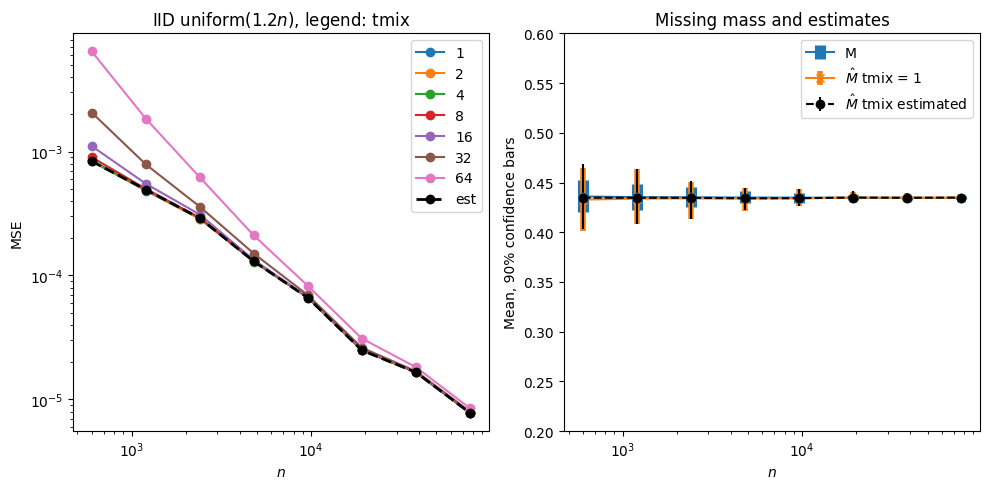

In [6]:
#Plot results for IID uniform
#[PMT24]: Figure 1 (similar to it, of course)
f, (ax0,ax1) = plt.subplots(ncols = 2, tight_layout=True, figsize=(10,5))
for tmix in tset:
    if tmix == 'est':
        ax0.plot(nset, [MSE[(n,0,'est')][0] for n in nset], 'ko--',linewidth=2)
    else:    
        ax0.plot(nset, [MSE[(n,0,tmix)][0] for n in nset], 'o-')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.legend([str(tmix) for tmix in tset])
ax0.set_title('IID uniform$(1.2n)$, legend: tmix')
ax0.set_xlabel('$n$')
ax0.set_ylabel('MSE')

lower = [M[(n,0,1)][0]-M[(n,0,1)][2] for n in nset]
upper = [M[(n,0,1)][1]-M[(n,0,1)][0] for n in nset]
ax1.errorbar(nset, [M[(n,0,1)][0] for n in nset], yerr = [lower,upper],fmt='o-',elinewidth=8)
lower = [Mhat[(n,0,1)][0]-Mhat[(n,0,1)][2] for n in nset]
upper = [Mhat[(n,0,1)][1]-Mhat[(n,0,1)][0] for n in nset]
ax1.errorbar(nset, [Mhat[(n,0,1)][0] for n in nset], yerr = [lower,upper],fmt='x-',elinewidth=4)
lower = [Mhat[(n,0,'est')][0]-Mhat[(n,0,'est')][2] for n in nset]
upper = [Mhat[(n,0,'est')][1]-Mhat[(n,0,'est')][0] for n in nset]
ax1.errorbar(nset, [Mhat[(n,0,'est')][0] for n in nset], yerr = [lower,upper],fmt='ko--')
ax1.set_ylim([0.2,0.6])
ax1.set_xscale('log')
ax1.set_xlabel('$n$')
ax1.set_ylabel('Mean, 90% confidence bars')
ax1.set_title('Missing mass and estimates')
ax1.legend(['M','$\hat{M}$ tmix = 1','$\hat{M}$ tmix estimated'])
plt.show()

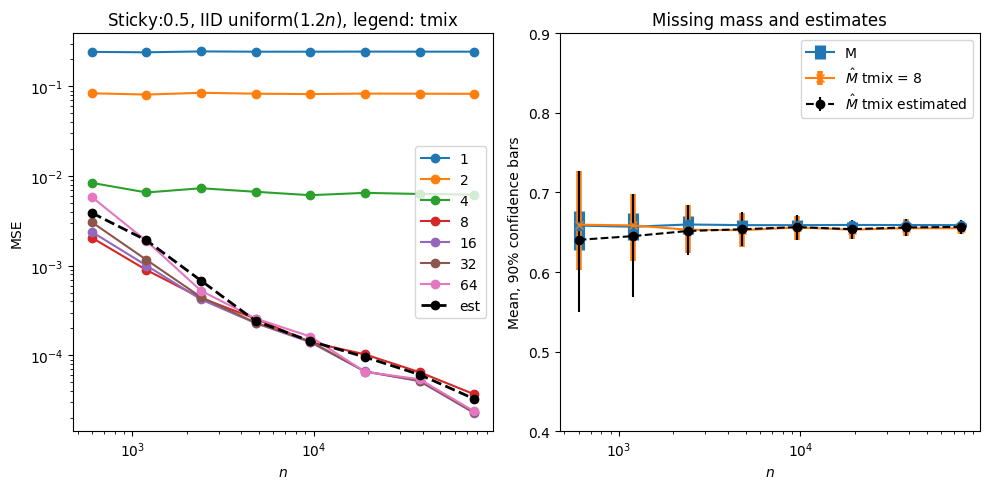

In [7]:
#Plot results for a sticky Markov chain with one stickiness parameter
#[PMT24]: Figure 2 (al=0.5, tbest=8)
def plotres(ax0,ax1,tset,nset,MSE,M,Mhat,al,tbest):
    for tmix in tset:
        if tmix == 'est':
            ax0.plot(nset, [MSE[(n,al,'est')][0] for n in nset], 'ko--', linewidth=2)
        else:    
            ax0.plot(nset, [MSE[(n,al,tmix)][0] for n in nset], 'o-')
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.legend([str(tmix) for tmix in tset])
    ax0.set_title('Sticky:'+str(al)+', IID uniform$(1.2n)$, legend: tmix')
    ax0.set_xlabel('$n$')
    ax0.set_ylabel('MSE')

    lower = [M[(n,al,tbest)][0]-M[(n,al,tbest)][2] for n in nset]
    upper = [M[(n,al,tbest)][1]-M[(n,al,tbest)][0] for n in nset]
    ax1.errorbar(nset, [M[(n,al,tbest)][0] for n in nset], yerr = [lower,upper],fmt='o-',elinewidth=8)
    lower = [Mhat[(n,al,tbest)][0]-Mhat[(n,al,tbest)][2] for n in nset]
    upper = [Mhat[(n,al,tbest)][1]-Mhat[(n,al,tbest)][0] for n in nset]
    ax1.errorbar(nset, [Mhat[(n,al,tbest)][0] for n in nset], yerr = [lower,upper],fmt='x-',elinewidth=4)
    lower = [Mhat[(n,al,'est')][0]-Mhat[(n,al,'est')][2] for n in nset]
    upper = [Mhat[(n,al,'est')][1]-Mhat[(n,al,'est')][0] for n in nset]
    ax1.errorbar(nset, [Mhat[(n,al,'est')][0] for n in nset], yerr = [lower,upper],fmt='ko--')
    ax1.set_xscale('log')
    ax1.set_xlabel('$n$')
    ax1.set_ylabel('Mean, 90% confidence bars')
    ax1.set_title('Missing mass and estimates')
    ax1.legend(['M','$\hat{M}$ tmix = '+str(tbest),'$\hat{M}$ tmix estimated'])

f, (ax0,ax1) = plt.subplots(ncols = 2, tight_layout=True, figsize=(10,5))
plotres(ax0,ax1,tset,nset,MSE,M,Mhat,0.5,8)
ax1.set_ylim([0.4,0.9])
plt.show()

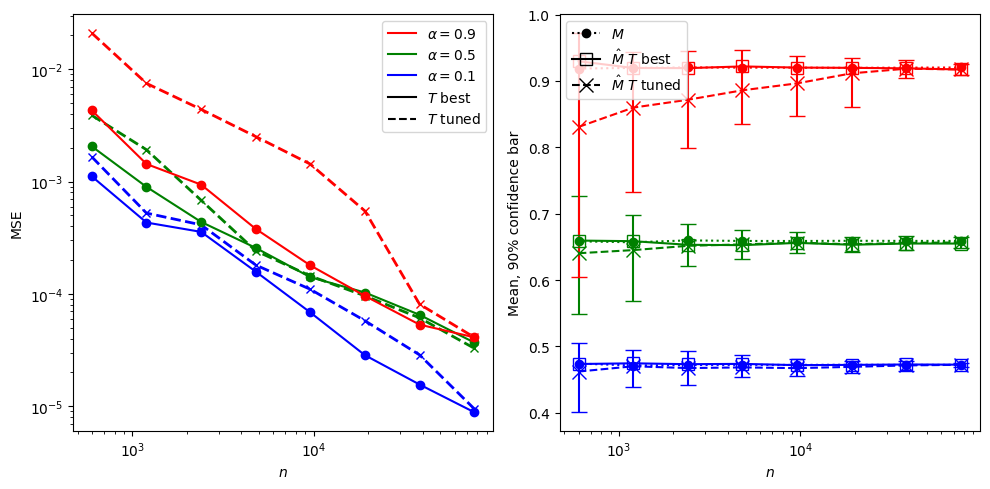

In [8]:
#Plot and compare multiple stickiness parameters
#[PMT24]: Figure 3 (legends vary a bit here)
f, (ax0,ax1) = plt.subplots(ncols = 2, tight_layout=True, figsize=(10,5))
ax0.plot(nset, [MSE[(n,0.1,'est')][0] for n in nset], 'bx--', linewidth=2)
ax0.plot(nset, [MSE[(n,0.1,4)][0] for n in nset], 'bo-')
ax0.plot(nset, [MSE[(n,0.5,'est')][0] for n in nset], 'gx--', linewidth=2)
ax0.plot(nset, [MSE[(n,0.5,8)][0] for n in nset], 'go-')
ax0.plot(nset, [MSE[(n,0.9,'est')][0] for n in nset], 'rx--', linewidth=2)
ax0.plot(nset, [MSE[(n,0.9,64)][0] for n in nset], 'ro-')
ax0.set_xscale('log')
ax0.set_yscale('log')
line4 = mlines.Line2D([], [], color='red', label='$\\alpha=0.9$')
line5 = mlines.Line2D([], [], color='green', label='$\\alpha=0.5$')
line6 = mlines.Line2D([], [], color='blue', label='$\\alpha=0.1$')
line7 = mlines.Line2D([], [], color='black', label='$T$ best')
line8 = mlines.Line2D([], [], linestyle='dashed',color='black', label='$T$ tuned')

ax0.legend(handles=[line4,line5,line6,line7,line8])
ax0.set_xlabel('$n$')
ax0.set_ylabel('MSE')

def plotmeanconf(ax,M,Mhat,al,tbest,colour):
    lower = [M[(n,al,tbest)][0]-M[(n,al,tbest)][2] for n in nset]
    upper = [M[(n,al,tbest)][1]-M[(n,al,tbest)][0] for n in nset]
    ax.errorbar(nset, [M[(n,al,tbest)][0] for n in nset],fmt=colour+'o:')
    lower = [Mhat[(n,al,tbest)][0]-Mhat[(n,al,tbest)][2] for n in nset]
    upper = [Mhat[(n,al,tbest)][1]-Mhat[(n,al,tbest)][0] for n in nset]
    ax.errorbar(nset, [Mhat[(n,al,tbest)][0] for n in nset],fmt=colour+'s-',mfc='none',markersize=8)
    lower = [Mhat[(n,al,'est')][0]-Mhat[(n,al,'est')][2] for n in nset]
    upper = [Mhat[(n,al,'est')][1]-Mhat[(n,al,'est')][0] for n in nset]
    ax.errorbar(nset, [Mhat[(n,al,'est')][0] for n in nset], yerr = [lower,upper],fmt=colour+'x--',markersize=10,capsize=6)

plotmeanconf(ax1,M,Mhat,0.1,4,'b')
plotmeanconf(ax1,M,Mhat,0.5,8,'g')
plotmeanconf(ax1,M,Mhat,0.9,64,'r')
ax1.set_xscale('log')
ax1.set_xlabel('$n$')
ax1.set_ylabel('Mean, 90% confidence bar')

line1 = mlines.Line2D([], [], linestyle='dotted', color='black', marker='o', label='$M$')
line2 = mlines.Line2D([], [], color='black', marker='s', markersize=8, mfc='none', label='$\hat{M}$ $T$ best')
line3 = mlines.Line2D([], [], linestyle='dashed', color='black', marker='x', markersize=10, label='$\hat{M}$ $T$ tuned')
ax1.legend(handles=[line1,line2,line3])

plt.show()